# Library Imports


In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 29 15:53:57 2022

@author: joaquinruiz
"""
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedGroupKFold, GroupKFold, LeaveOneGroupOut
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from itertools import product, compress
import os
import warnings

#Function to construct average confusion matrices

In [35]:
def plot_mean_confumat(cm_avr, cm_sd, ax, title, clas_lab, set_cbar={'cmap':'viridis','cbar_shrink':1,'cmax':None,'cmin':None}, fontsz = 12):
  if set_cbar['cmin'] or set_cbar['cmax']:
    cmap_min, cmap_max = set_cbar['cmin'], set_cbar['cmax']
  else:
    cmap_min, cmap_max = cm_avr.min(), cm_avr.max()

  im=ax.imshow(cm_avr,vmin=cmap_min, vmax=cmap_max,interpolation='nearest',cmap=set_cbar['cmap'])


  cc_min, cc_max = im.cmap(0), im.cmap(256)
  cbar = plt.colorbar(im,ax=ax,shrink=set_cbar['cbar_shrink'])
  cbar.ax.tick_params(labelsize=fontsz)

  thresh = (cmap_max + cmap_min) / 2.0
  n_classes = cm_avr.shape[0]
  for r,c in product(np.arange(n_classes),np.arange(n_classes)):
      color = cc_max if cm_avr[r, c] < thresh else cc_min
      text = ax.text(c,r,'{mean:.2f}\n ({std:.2f})'.format(mean=cm_avr[r,c],
                      std=cm_sd[r,c]),ha="center",va="center",color=color, fontsize = fontsz)
  ax.set(xticks=np.arange(n_classes), yticks=np.arange(n_classes),
         xticklabels=clas_lab, yticklabels=clas_lab,
         ylabel="True label", xlabel="Predicted label")
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fontsz)
  ax.set_title(title,{'fontsize':fontsz})
  plt.tight_layout()

In [36]:
!git clone https://github.com/joaquinr-uner/voice_waveshape.git

fatal: destination path 'voice_waveshape' already exists and is not an empty directory.


 # Training-Validation with k-Fold Cross-validation


## Data Loading

In [37]:
R = 15
N = 20
df = pd.read_csv('voice_waveshape/Features_Parkinson.csv')
n_splits = 10
X_org = df.iloc[:,:-2]
y = df['Label']
groups = df['PatientID']
do_plot = False
X_org

,Error,TV_B1,TV_F0,TV_HAF_1,TV_HAF_2,TV_HAF_3,TV_HAF_4,TV_HAF_5,TV_HAF_6,TV_HAF_7,...,S_6,S_7,S_8,S_9,S_10,S_11,S_12,S_13,S_14,S_15
0,0.551138,1.850005e-07,7.658151e-08,9.055832,3.938677,3.818863,7.724371,9.394340,8.098712,65.529230,...,1.128880,6.320318,1.124661,3.072495,0.552619,1.006659,2.754058,3.582243,1.202115,0.273616
1,0.656459,1.818675e-07,7.582490e-08,0.631198,1.288502,0.461255,0.632353,0.860171,0.938020,3.252380,...,1.553505,2.032029,2.757955,2.298387,0.714290,1.264109,2.211892,2.619999,1.036763,0.258833
2,0.439405,2.069620e-07,6.344549e-08,3.042276,4.088423,4.116339,2.839102,4.384079,4.028500,3.509658,...,2.044802,6.305511,4.122868,1.188710,1.619404,2.258232,3.131639,3.115438,0.640100,0.367131
3,0.495455,7.680651e-07,1.244728e-07,5.028178,13.925355,8.037162,306.005676,50.636860,29.703532,31.031062,...,0.137470,0.148627,0.128206,0.042742,0.011197,0.003850,0.003467,0.005873,0.025089,0.010362
4,0.528955,7.394598e-07,1.145997e-07,5.870742,259.212628,25.234067,30.754408,76.889643,119.016195,67.586426,...,0.118136,0.053228,0.073571,0.030706,0.004647,0.013320,0.014762,0.027246,0.074398,0.007548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.366268,1.116099e-07,8.241938e-08,2.741207,1.631182,3.864266,7.912805,6.177079,3.566279,4.486684,...,0.047670,0.073950,0.165547,0.476311,1.086493,0.253511,0.527205,0.510890,0.240815,0.097903
596,0.351051,1.472870e-07,7.444042e-08,1.657526,2.262309,1.881949,3.668116,8.106305,3.500219,8.008461,...,0.040857,0.084943,0.250538,1.086893,0.483621,0.410039,0.436941,0.138784,0.071370,0.068494
597,0.418127,2.810033e-08,1.127941e-07,1.102266,1.869762,3.711956,6.126774,2.104629,5.807364,4.574493,...,0.107182,0.082021,0.076212,0.095015,0.198743,0.288924,0.481510,0.614908,0.549782,0.395819
598,0.252453,4.331125e-08,1.088915e-07,0.854212,1.942212,2.008534,2.396305,1.727611,1.909566,1.892376,...,0.076697,0.062515,0.094029,0.101561,0.213239,0.900970,0.258561,0.364527,0.418129,0.494793


In [38]:
Xnstd = X_org
Xnstd.columns


Index(['Error', 'TV_B1', 'TV_F0', 'TV_HAF_1', 'TV_HAF_2', 'TV_HAF_3',
       'TV_HAF_4', 'TV_HAF_5', 'TV_HAF_6', 'TV_HAF_7', 'TV_HAF_8', 'TV_HAF_9',
       'TV_HAF_10', 'TV_HAF_11', 'TV_HAF_12', 'TV_HAF_13', 'TV_HAF_14', 'S_1',
       'S_2', 'S_3', 'S_4', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_10', 'S_11',
       'S_12', 'S_13', 'S_14', 'S_15'],
      dtype='object')

In [39]:
cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)
n_splits = cv.get_n_splits(groups=groups)

## SVM RBF
Hiperparameters to be optimized:


*   $C$. Range: $1^{-1} - 10000$. $L = 13$
*   $\gamma$. Range: $\frac{0.001}{N_{features}} - \frac{1000}{N_{features}}$. $L = 9$


                             

In [40]:
VC = np.logspace(-1,5,num=13)

Y = y.to_numpy()
scaler = StandardScaler().fit(Xnstd)
X = scaler.transform(Xnstd)

Vgamm = 1/X.shape[1]*np.logspace(-3,3,num=9)


In [41]:
VC

array([1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05])

In [42]:
Vgamm

array([3.12500000e-05, 1.75731664e-04, 9.88211769e-04, 5.55712316e-03,
       3.12500000e-02, 1.75731664e-01, 9.88211769e-01, 5.55712316e+00,
       3.12500000e+01])

In [43]:
it = product(VC,Vgamm)

V_scores = []
for C, gam in it:
  net_svm = SVC(C = C, gamma = gam,  class_weight='balanced')
  #net_svm = SVC()
  cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)
  #cv = GroupKFold(n_splits=n_splits)
  #cv = KFold(n_splits=n_splits,shuffle=True)
  score_svm = np.zeros((n_splits))
  acc_svm = np.zeros((n_splits))
  cm = np.zeros((n_splits,2,2))
  for i, (Train, Test) in enumerate(cv.split(X,Y,groups)):
      Xtrain, Xtest, Ytrain, Ytest = X[Train], X[Test], Y[Train], Y[Test]
      net_svm.fit(Xtrain,Ytrain)
      y_pred_svm = net_svm.predict(Xtest)
      score_svm[i] = balanced_accuracy_score(Ytest, y_pred_svm)
      acc_svm[i] = accuracy_score(Ytest,y_pred_svm)
      cm[i,:,:] = confusion_matrix(Ytest,y_pred_svm,normalize='true')

  V_scores.append({'C':C,'gamma':gam,'scores':score_svm,'mean_score':np.mean(score_svm),'acc_score':np.mean(acc_svm),'confumat':cm})

In [44]:
mean_scores = [score['mean_score'] for score in V_scores]
np.argmax(mean_scores)


40

In [45]:
best = V_scores[np.argmax(mean_scores)]
best

{'C': 10.0,
 'gamma': 0.03125,
 'scores': array([0.48333333, 0.76666667, 0.68333333, 0.6       , 0.73333333,
        0.46666667, 0.9       , 0.75      , 0.85      , 0.66666667]),
 'mean_score': 0.69,
 'acc_score': 0.69,
 'confumat': array([[[0.43333333, 0.56666667],
         [0.46666667, 0.53333333]],
 
        [[0.73333333, 0.26666667],
         [0.2       , 0.8       ]],
 
        [[0.6       , 0.4       ],
         [0.23333333, 0.76666667]],
 
        [[0.53333333, 0.46666667],
         [0.33333333, 0.66666667]],
 
        [[0.73333333, 0.26666667],
         [0.26666667, 0.73333333]],
 
        [[0.66666667, 0.33333333],
         [0.73333333, 0.26666667]],
 
        [[0.86666667, 0.13333333],
         [0.06666667, 0.93333333]],
 
        [[0.73333333, 0.26666667],
         [0.23333333, 0.76666667]],
 
        [[0.83333333, 0.16666667],
         [0.13333333, 0.86666667]],
 
        [[0.73333333, 0.26666667],
         [0.4       , 0.6       ]]])}

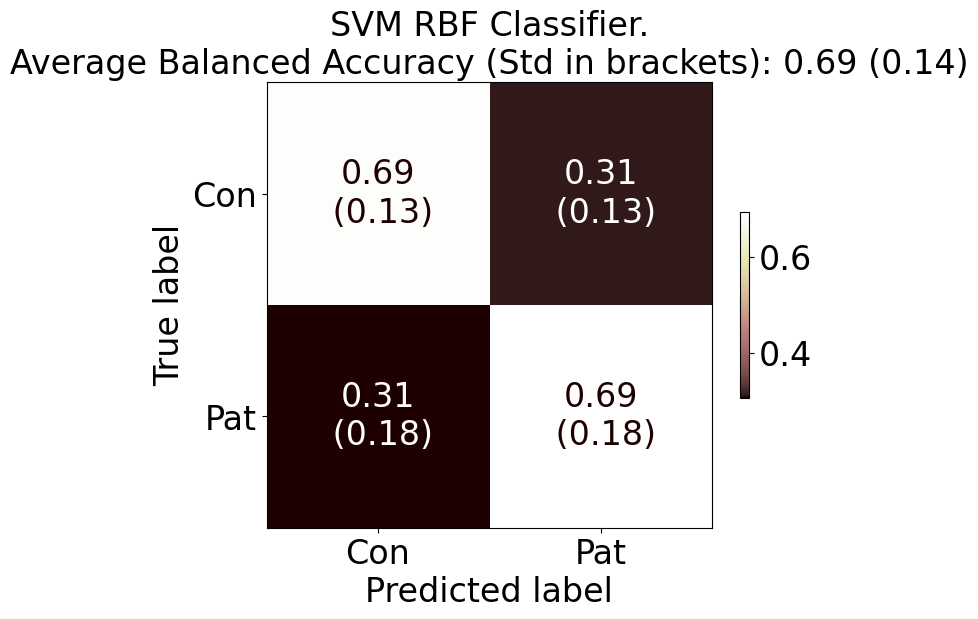

In [46]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
cbars = 0.3
fntsz = 24

cm_avr = np.mean(best['confumat'],axis=0)
cm_sd = np.std(best['confumat'],axis=0)

title = f'SVM RBF Classifier (kFCV).' + '\n' + f'Average Balanced Accuracy (Std in brackets): {str(round(np.mean(best["scores"]),2))} ({str(round(np.std(best["scores"]),2))})'
plot_mean_confumat(cm_avr, cm_sd, ax, title, ['Con','Pat'], set_cbar = {'cmap':'pink','cbar_shrink':cbars, 'cmin':None, 'cmax':None}, fontsz = fntsz)


## Random Forest

Hiperparameters to be optimized:

* Number of Classifiers: $n_c$
* Minimum number of samples per branch: $n_{samp}$

In [47]:
import warnings
warnings.filterwarnings('ignore')
n_feat = Xnstd.shape[1]

n_f = [2, 5, 10, 20, 30, 40, 50]

n_c = [10, 25, 50, 75, 100, 150, 200, 300, 500]
it = product(n_c,n_f)

In [48]:
V_scores = []

Y = y.to_numpy()
scaler = StandardScaler().fit(Xnstd)
X = scaler.transform(Xnstd)

for nc, nf in it:
  score = np.zeros((n_splits))
  acc = np.zeros((n_splits))
  cm = np.zeros((n_splits,2,2))
  cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)
  #cv = GroupKFold(n_splits=n_splits)
  #cv = KFold(n_splits=n_splits,shuffle=True)
  test_score_best=0
  for i, (Train, Test) in enumerate(cv.split(X,Y,groups)):
      X_train, y_train, X_test, Y_test = X[Train], Y[Train], X[Test], Y[Test]
      clf = RandomForestClassifier(n_estimators=nc,min_samples_split = nf)
      clf.fit(X_train,y_train)
      y_pred = clf.predict(X_test)
      score[i] = balanced_accuracy_score(Y_test, y_pred)
      acc[i] = accuracy_score(Y_test,y_pred)
      cm[i,:,:] = confusion_matrix(Y_test,y_pred,normalize='true')

      if score[i]>test_score_best:
          test_score_best=score[i]
          clf_best = clf
          train_best=Train
          test_best=Test
  mean_score = np.mean(score)
  V_scores.append({'number_class':nc,'number_samp':nf,'score_vector':score,'mean_score':mean_score,'confumat':cm,'feature_importance':clf.feature_importances_})

In [49]:
mean_scores = [score['mean_score'] for score in V_scores]
np.argmax(mean_scores)
best = V_scores[np.argmax(mean_scores)]
best

{'number_class': 150,
 'number_samp': 10,
 'score_vector': array([0.55      , 0.83333333, 0.56666667, 0.8       , 0.93333333,
        0.68333333, 0.86666667, 0.78333333, 0.78333333, 0.58333333]),
 'mean_score': 0.7383333333333333,
 'confumat': array([[[0.6       , 0.4       ],
         [0.5       , 0.5       ]],
 
        [[0.76666667, 0.23333333],
         [0.1       , 0.9       ]],
 
        [[0.46666667, 0.53333333],
         [0.33333333, 0.66666667]],
 
        [[0.76666667, 0.23333333],
         [0.16666667, 0.83333333]],
 
        [[0.86666667, 0.13333333],
         [0.        , 1.        ]],
 
        [[0.6       , 0.4       ],
         [0.23333333, 0.76666667]],
 
        [[0.83333333, 0.16666667],
         [0.1       , 0.9       ]],
 
        [[0.73333333, 0.26666667],
         [0.16666667, 0.83333333]],
 
        [[0.8       , 0.2       ],
         [0.23333333, 0.76666667]],
 
        [[0.33333333, 0.66666667],
         [0.16666667, 0.83333333]]]),
 'feature_importance': arra

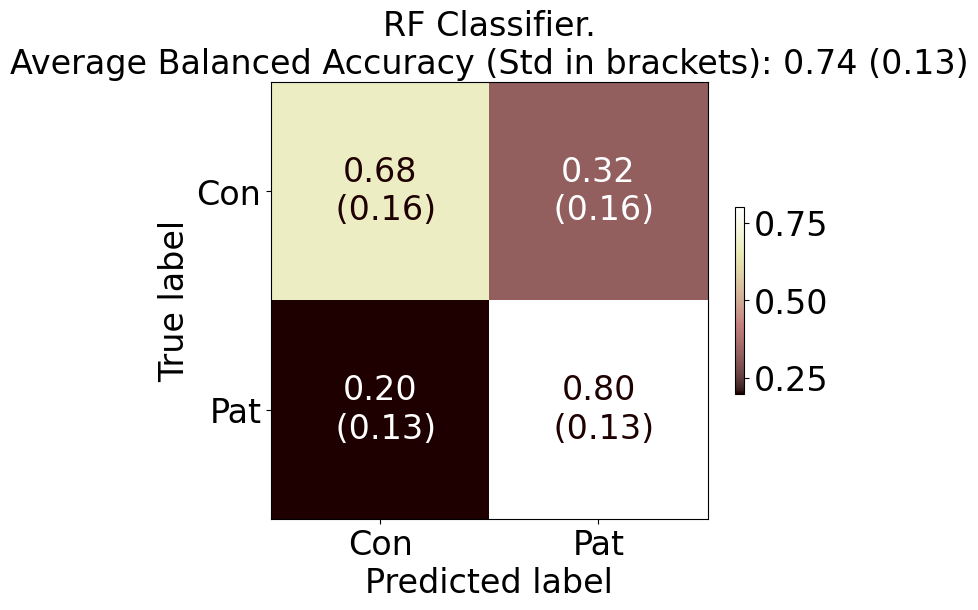

In [50]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
cbars = 0.3
fntsz = 24

cm_avr = np.mean(best['confumat'],axis=0)
cm_sd = np.std(best['confumat'],axis=0)

title = f'RF Classifier (kFCV).' + '\n' + f'Average Balanced Accuracy (Std in brackets): {str(round(np.mean(best["score_vector"]),2))} ({str(round(np.std(best["score_vector"]),2))})'
plot_mean_confumat(cm_avr, cm_sd, ax, title, ['Con','Pat'], set_cbar = {'cmap':'pink','cbar_shrink':cbars, 'cmin':None, 'cmax':None}, fontsz = fntsz)


## AdaBoost Classifier

Hiperparameters to be optimized:
* Number of Classifiers: $n_c$

In [51]:
import warnings
warnings.filterwarnings('ignore')
n_feat = Xnstd.shape[1]

n_c = [10, 25, 50, 75, 100, 150, 200]

In [52]:
Y_test

array(['Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy'],
      dtype=object)

In [53]:
V_scores = []

Y = y.to_numpy()
scaler = StandardScaler().fit(Xnstd)
X = scaler.transform(Xnstd)

for nc in n_c:
  score = np.zeros((n_splits))
  acc = np.zeros((n_splits))
  cm = np.zeros((n_splits,2,2))
  cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)
  #cv = GroupKFold(n_splits=n_splits)
  #cv = KFold(n_splits=n_splits,shuffle=True)
  test_score_best=0
  for i, (Train, Test) in enumerate(cv.split(X,Y,groups)):
      X_train, y_train, X_test, Y_test = X[Train], Y[Train], X[Test], Y[Test]
      clf = AdaBoostClassifier(n_estimators=nc)
      clf.fit(X_train,y_train)
      y_pred = clf.predict(X_test)
      score[i] = balanced_accuracy_score(Y_test, y_pred)
      acc[i] = accuracy_score(Y_test,y_pred)
      cm[i,:,:] = confusion_matrix(Y_test,y_pred,normalize='true')

      if score[i]>test_score_best:
          test_score_best=score[i]
          clf_best = clf
          train_best=Train
          test_best=Test
  mean_score = np.mean(score)
  V_scores.append({'number_class':nc,'score_vector':score,'mean_score':mean_score,'confumat':cm,'feature_importance':clf.feature_importances_})

In [54]:
mean_scores = [score['mean_score'] for score in V_scores]
np.argmax(mean_scores)
best = V_scores[np.argmax(mean_scores)]
best

{'number_class': 100,
 'score_vector': array([0.61666667, 0.65      , 0.71666667, 0.71666667, 0.66666667,
        0.55      , 0.8       , 0.75      , 0.83333333, 0.78333333]),
 'mean_score': 0.7083333333333333,
 'confumat': array([[[0.4       , 0.6       ],
         [0.16666667, 0.83333333]],
 
        [[0.6       , 0.4       ],
         [0.3       , 0.7       ]],
 
        [[0.63333333, 0.36666667],
         [0.2       , 0.8       ]],
 
        [[0.73333333, 0.26666667],
         [0.3       , 0.7       ]],
 
        [[0.5       , 0.5       ],
         [0.16666667, 0.83333333]],
 
        [[0.53333333, 0.46666667],
         [0.43333333, 0.56666667]],
 
        [[0.86666667, 0.13333333],
         [0.26666667, 0.73333333]],
 
        [[0.66666667, 0.33333333],
         [0.16666667, 0.83333333]],
 
        [[0.8       , 0.2       ],
         [0.13333333, 0.86666667]],
 
        [[0.83333333, 0.16666667],
         [0.26666667, 0.73333333]]]),
 'feature_importance': array([0.05, 0.08, 0.04,

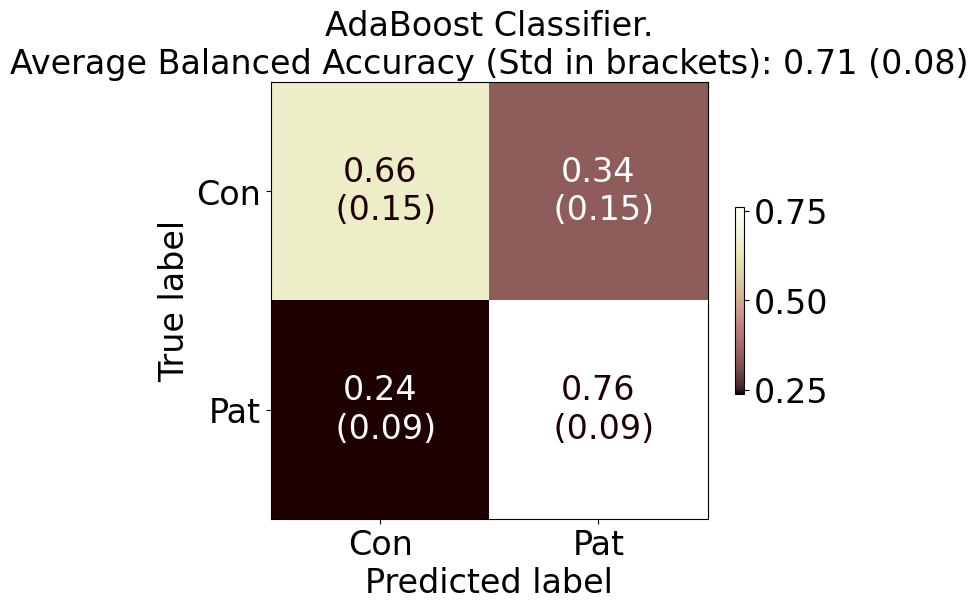

In [55]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
cbars = 0.3
fntsz = 24

cm_avr = np.mean(best['confumat'],axis=0)
cm_sd = np.std(best['confumat'],axis=0)

title = f'AdaBoost Classifier (kFCV).' + '\n' + f'Average Balanced Accuracy (Std in brackets): {str(round(np.mean(best["score_vector"]),2))} ({str(round(np.std(best["score_vector"]),2))})'
plot_mean_confumat(cm_avr, cm_sd, ax, title, ['Con','Pat'], set_cbar = {'cmap':'pink','cbar_shrink':cbars, 'cmin':None, 'cmax':None}, fontsz = fntsz)


# Training-Validation with Leave-One-Subject-Out Cross-Validation


In [56]:
cv = GroupKFold(n_splits=n_splits)

n_splits = cv.get_n_splits(groups=groups)

In [57]:
n_splits

10

## SVM RBF
Hiperparameters to be optimized:


*   $C$. Range: $1^{-1} - 10000$. $L = 13$
*   $\gamma$. Range: $\frac{0.001}{N_{features}} - \frac{1000}{N_{features}}$. $L = 9$


                             

In [58]:
VC = np.logspace(-1,5,num=13)

Y = y.to_numpy()
scaler = StandardScaler().fit(Xnstd)
X = scaler.transform(Xnstd)

Vgamm = 1/X.shape[1]*np.logspace(-3,3,num=9)


In [59]:
VC

array([1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05])

In [60]:
Vgamm

array([3.12500000e-05, 1.75731664e-04, 9.88211769e-04, 5.55712316e-03,
       3.12500000e-02, 1.75731664e-01, 9.88211769e-01, 5.55712316e+00,
       3.12500000e+01])

In [61]:
it = product(VC,Vgamm)

V_scores = []
for C, gam in it:
  net_svm = SVC(C = C, gamma = gam,  class_weight='balanced')
  #net_svm = SVC()
  #cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)
  cv = GroupKFold(n_splits=n_splits)
  #cv = KFold(n_splits=n_splits,shuffle=True)
  score_svm = np.zeros((n_splits))
  acc_svm = np.zeros((n_splits))
  cm = np.zeros((n_splits,2,2))
  for i, (Train, Test) in enumerate(cv.split(X,Y,groups)):
      Xtrain, Xtest, Ytrain, Ytest = X[Train], X[Test], Y[Train], Y[Test]
      net_svm.fit(Xtrain,Ytrain)
      y_pred_svm = net_svm.predict(Xtest)
      score_svm[i] = balanced_accuracy_score(Ytest, y_pred_svm)
      acc_svm[i] = accuracy_score(Ytest,y_pred_svm)
      aux = confusion_matrix(Ytest,y_pred_svm)
      if aux.size==1:
        if set(Ytest)=={'Healthy'}:
          cm[i,:,:] = np.array([[Ytest.size, 0],[0, 0]])
        else:
          cm[i,:,:] = np.array([[0, 0],[0, Ytest.size]])
      else:
        cm[i,:,:] = aux;

  V_scores.append({'C':C,'gamma':gam,'scores':score_svm,'mean_score':np.mean(score_svm),'acc_score':np.mean(acc_svm),'confumat':cm})

In [62]:
mean_scores = [score['mean_score'] for score in V_scores]
np.argmax(mean_scores)


66

In [63]:
best = V_scores[np.argmax(mean_scores)]
best

{'C': 316.22776601683796,
 'gamma': 0.005557123156371634,
 'scores': array([0.68333333, 0.7       , 0.63333333, 0.63194444, 0.86666667,
        0.81666667, 0.71666667, 0.5       , 0.68333333, 0.81944444]),
 'mean_score': 0.7051388888888889,
 'acc_score': 0.705,
 'confumat': array([[[20., 10.],
         [ 9., 21.]],
 
        [[23.,  7.],
         [11., 19.]],
 
        [[18., 12.],
         [10., 20.]],
 
        [[26., 10.],
         [11., 13.]],
 
        [[25.,  5.],
         [ 3., 27.]],
 
        [[24.,  6.],
         [ 5., 25.]],
 
        [[22.,  8.],
         [ 9., 21.]],
 
        [[14., 16.],
         [14., 16.]],
 
        [[20., 10.],
         [ 9., 21.]],
 
        [[22.,  2.],
         [10., 26.]]])}

Text(0.5, 1.0, 'SVM RBF Classifier (LOSOCV).\nAverage Accuracy: 0.71')

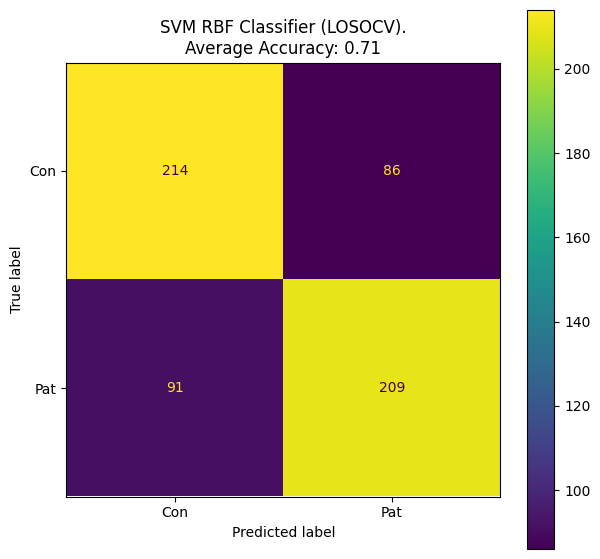

In [66]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
title = f'SVM RBF Classifier (LOSOCV).' + '\n' + f'Average Accuracy: {str(round(np.mean(best["scores"]),2))}'
cm_display = ConfusionMatrixDisplay(best['confumat'].sum(axis=0),display_labels=['Con','Pat']).plot(ax=ax,values_format='.3g')
ax.set_title(title)

## Random Forest

Hiperparameters to be optimized:

* Number of Classifiers: $n_c$
* Minimum number of samples per branch: $n_{samp}$

In [67]:
import warnings
warnings.filterwarnings('ignore')
n_feat = Xnstd.shape[1]

n_f = [2, 5, 10, 20, 30]

n_c = [10, 50, 100, 200, 500]
it = product(n_c,n_f)

In [68]:
V_scores = []

Y = y.to_numpy()
scaler = StandardScaler().fit(Xnstd)
X = scaler.transform(Xnstd)

for nc, nf in it:
  score = np.zeros((n_splits))
  acc = np.zeros((n_splits))
  cm = np.zeros((n_splits,2,2))
  #cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)
  cv = GroupKFold(n_splits=n_splits)
  #cv = KFold(n_splits=n_splits,shuffle=True)
  test_score_best=0
  for i, (Train, Test) in enumerate(cv.split(X,Y,groups)):
      X_train, y_train, X_test, Y_test = X[Train], Y[Train], X[Test], Y[Test]
      clf = RandomForestClassifier(n_estimators=nc,min_samples_split = nf)
      clf.fit(X_train,y_train)
      y_pred = clf.predict(X_test)
      score[i] = balanced_accuracy_score(Y_test, y_pred)
      acc[i] = accuracy_score(Y_test,y_pred)
      aux = confusion_matrix(Y_test,y_pred)
      if aux.size==1:
        if set(Y_test)=={'Healthy'}:
          cm[i,:,:] = np.array([[Ytest.size, 0],[0, 0]])
        else:
          cm[i,:,:] = np.array([[0, 0],[0, Ytest.size]])
      else:
        cm[i,:,:] = aux;

      if score[i]>test_score_best:
          test_score_best=score[i]
          clf_best = clf
          train_best=Train
          test_best=Test
  mean_score = np.mean(score)
  V_scores.append({'number_class':nc,'number_samp':nf,'score_vector':score,'mean_score':mean_score,'confumat':cm,'feature_importance':clf.feature_importances_})

In [69]:
mean_scores = [score['mean_score'] for score in V_scores]
np.argmax(mean_scores)
best = V_scores[np.argmax(mean_scores)]
best

{'number_class': 200,
 'number_samp': 30,
 'score_vector': array([0.71666667, 0.8       , 0.6       , 0.89583333, 0.81666667,
        0.8       , 0.68333333, 0.5       , 0.65      , 0.86805556]),
 'mean_score': 0.7330555555555556,
 'confumat': array([[[23.,  7.],
         [10., 20.]],
 
        [[20., 10.],
         [ 2., 28.]],
 
        [[14., 16.],
         [ 8., 22.]],
 
        [[33.,  3.],
         [ 3., 21.]],
 
        [[22.,  8.],
         [ 3., 27.]],
 
        [[21.,  9.],
         [ 3., 27.]],
 
        [[17., 13.],
         [ 6., 24.]],
 
        [[13., 17.],
         [13., 17.]],
 
        [[17., 13.],
         [ 8., 22.]],
 
        [[23.,  1.],
         [ 8., 28.]]]),
 'feature_importance': array([0.02580221, 0.2004396 , 0.04989896, 0.02323768, 0.02667645,
        0.02590978, 0.03228127, 0.01583439, 0.01749249, 0.01541727,
        0.01362875, 0.0128203 , 0.01722673, 0.01456984, 0.01246037,
        0.01234509, 0.01209608, 0.11403692, 0.05744908, 0.01975699,
        0.042

Text(0.5, 1.0, 'RF Classifier (LOSOCV).\nAverage Accuracy: 0.73')

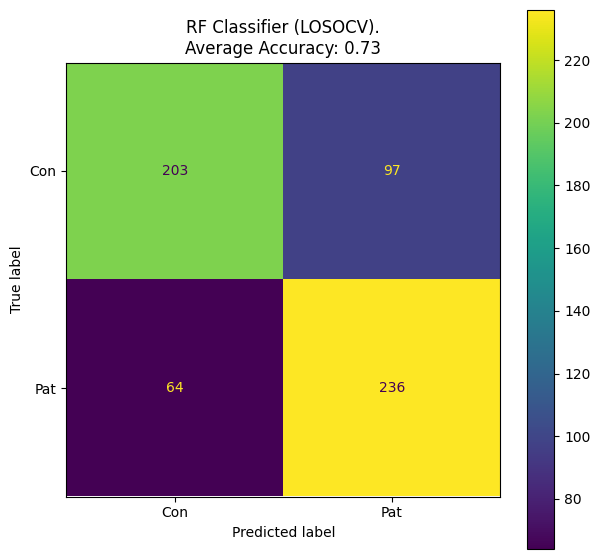

In [70]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
title = f'RF Classifier (LOSOCV).' + '\n' + f'Average Accuracy: {str(round(np.mean(best["mean_score"]),2))}'
cm_display = ConfusionMatrixDisplay(best['confumat'].sum(axis=0),display_labels=['Con','Pat']).plot(ax=ax,values_format='.3g')
ax.set_title(title)


## AdaBoost Classifier

Hiperparameters to be optimized:
* Number of Classifiers: $n_c$


In [71]:
import warnings
warnings.filterwarnings('ignore')
n_feat = Xnstd.shape[1]

n_c = [10, 50, 100, 200]

In [72]:
Y_test

array(['Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson', 'Parkinson',
       'Parkinson', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy'], dtype=object)

In [73]:
V_scores = []

Y = y.to_numpy()
scaler = StandardScaler().fit(Xnstd)
X = scaler.transform(Xnstd)

for nc in n_c:
  score = np.zeros((n_splits))
  acc = np.zeros((n_splits))
  cm = np.zeros((n_splits,2,2))
  #cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)
  cv = GroupKFold(n_splits=n_splits)
  #cv = KFold(n_splits=n_splits,shuffle=True)
  test_score_best=0
  for i, (Train, Test) in enumerate(cv.split(X,Y,groups)):
      X_train, y_train, X_test, Y_test = X[Train], Y[Train], X[Test], Y[Test]
      clf = AdaBoostClassifier(n_estimators=nc)
      clf.fit(X_train,y_train)
      y_pred = clf.predict(X_test)
      score[i] = balanced_accuracy_score(Y_test, y_pred)
      acc[i] = accuracy_score(Y_test,y_pred)
      aux = confusion_matrix(Y_test,y_pred)
      if aux.size==1:
        if set(Y_test)=={'Healthy'}:
          cm[i,:,:] = np.array([[Ytest.size, 0],[0, 0]])
        else:
          cm[i,:,:] = np.array([[0, 0],[0, Ytest.size]])
      else:
        cm[i,:,:] = aux

      if score[i]>test_score_best:
          test_score_best=score[i]
          clf_best = clf
          train_best=Train
          test_best=Test
  mean_score = np.mean(score)
  V_scores.append({'number_class':nc,'score_vector':score,'mean_score':mean_score,'confumat':cm,'feature_importance':clf.feature_importances_})

In [74]:
mean_scores = [score['mean_score'] for score in V_scores]
np.argmax(mean_scores)
best = V_scores[np.argmax(mean_scores)]
best

{'number_class': 50,
 'score_vector': array([0.73333333, 0.7       , 0.65      , 0.8125    , 0.7       ,
        0.8       , 0.6       , 0.46666667, 0.66666667, 0.82638889]),
 'mean_score': 0.6955555555555556,
 'confumat': array([[[22.,  8.],
         [ 8., 22.]],
 
        [[19., 11.],
         [ 7., 23.]],
 
        [[15., 15.],
         [ 6., 24.]],
 
        [[30.,  6.],
         [ 5., 19.]],
 
        [[19., 11.],
         [ 7., 23.]],
 
        [[21.,  9.],
         [ 3., 27.]],
 
        [[16., 14.],
         [10., 20.]],
 
        [[14., 16.],
         [16., 14.]],
 
        [[18., 12.],
         [ 8., 22.]],
 
        [[23.,  1.],
         [11., 25.]]]),
 'feature_importance': array([0.02, 0.1 , 0.04, 0.02, 0.02, 0.06, 0.02, 0.02, 0.06, 0.02, 0.04,
        0.  , 0.04, 0.  , 0.  , 0.08, 0.02, 0.06, 0.08, 0.02, 0.06, 0.04,
        0.  , 0.04, 0.  , 0.02, 0.02, 0.02, 0.04, 0.  , 0.02, 0.02])}

Text(0.5, 1.0, 'AdaBoost Classifier (LOSOCV).\nAverage Accuracy: 0.7')

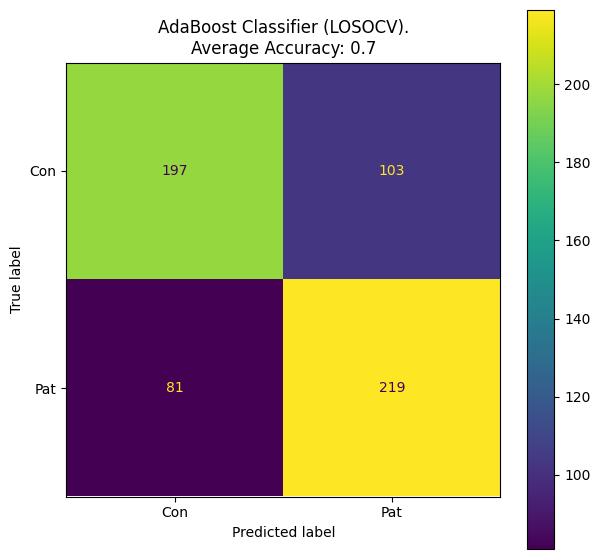

In [75]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
title = f'AdaBoost Classifier (LOSOCV).' + '\n' + f'Average Accuracy: {str(round(np.mean(best["mean_score"]),2))}'
cm_display = ConfusionMatrixDisplay(best['confumat'].sum(axis=0),display_labels=['Con','Pat']).plot(ax=ax,values_format='.3g')
ax.set_title(title)